# Taller 02: Redes recurrentes

**Integrantes:** (*Máximo grupos de 3*)

*   Luis Ojeda Gallegos
*   Paulo Espinoza Arriagada
*   Eduardo Moraga Ortega



El taller tiene como objetivo construir un clasificador utilizando redes recurrentes LSTM. Para esto, se replicará el problema visto en clases para la clasificación de nombres y apellidos al País que pertenecen. Una vez terminado la implementación del taller se pide comparar la eficiencia de ambos clasificadores a partir de la matriz de confusión.

Se debe tener en cuenta que en la evaluación de resultados se deben utilizar los mismos ejemplos. Por lo que deberá evaluar simultáneamente el clasificador de red recurrente simple y la red LSTM.

Las métricas solicitadas para la comparación de ambos clasifificadores son: Tasa de acierto, presición, sensibilidad (*recall*) y f1-score.

**Referencias:**
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report 

## 1. Preparar los datos

Utilizar el código mostrado en clases para cargar y acondicionar los datos:

In [ ]:
# librerias que utilizaremos en el modelo
import unicodedata
import string
import glob 
import os
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ubicacion en Google Drive de los archivos 
path = '/content/drive/My Drive/Deep Learning - Practica/names'

In [ ]:
# cargamos las 52 letras (mayusculas y minisculas) + los caracteres especiales
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Se define funcion para retirar las tildes
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters)
  
# Funcion para leer archivos separados por espacios
def readLines(filenames):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

# Leer los archivos y los cargaremos en un estructura de tipo diccionario
category_lines = {}
all_categories = []


for filename in glob.glob(f'{path}/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)
print(all_categories)
print(len(lines))

18
['German', 'Korean', 'Italian', 'Portuguese', 'French', 'Japanese', 'Vietnamese', 'Polish', 'Dutch', 'Spanish', 'Russian', 'Irish', 'Scottish', 'Czech', 'Chinese', 'English', 'Arabic', 'Greek']
195


## 2. Preparar los datos a formato Pytorch para red neuronal recurrente

Convertirmos las palabras (apellidos y nombres) a formato ***one-hot vector***. Además se contruye a formato tensor para poder utilizar la GPU vía Pytorch.

In [ ]:
# Encontrar el indice de una letra en all_letters
def letterToIndex(letter):
  return all_letters.find(letter)

# Construir un vector one-hot letter (Ilustrativo)
def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

# probare con mi apellido
print(lineToTensor('ortega'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## 3. Crear modelos

Para comparar los resultados se pide construir:


*   Modelo de red neuronal recurrente simple (vista en clases)
*   Modelo de red neuronal LSTM (Implementar)



In [ ]:
# Modelo de red neuronal recurrente simple, utilizado por el profesor en clases
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    # Construir componentes
    self.hidden_size = hidden_size
    # Salida de estado oculto
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    # Salida a estimar
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1) # vector --> [1 x (input + hidden)]
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
# se crea la instancia de rnn
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
# Modelo de red neuronal LSTM, propuesto para el laboratorio
class lstm_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(lstm_net, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        #LSTM
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2Cat = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()

    def forward(self, input):

        lstm_out, self.hidden = self.lstm(input, self.hidden)
        output = self.hidden2Cat(lstm_out[-1]) #many to one
        output = F.log_softmax(output, dim=1)

        return output

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))
        
lstm = lstm_net(n_letters, n_hidden, n_categories)

## 5. Generación de ejemplos aleatorios

Como se tienen diferentes palabras y categorías es que se optó por utilizar ejemplos generados de forma aleatoria. 

Para entrenar los modelos utilizaremos los mismo ejemplos generados por `randomChoiceExample`. Se debe considerar está condición en la implementación.

In [ ]:
# Implementación randomTrainingExample()

# Elige un elemento de lista en forma aleatoria
def randomChoice(lista):
  return lista[random.randint(0, len(lista)-1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  # Selecciono la palabra (nombre) de una categoria
  line = randomChoice(category_lines[category])
  # Convertir tensores
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

print(all_categories)
for i in range(20):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('categoria=', category, '/ palabra=', line)

['German', 'Korean', 'Italian', 'Portuguese', 'French', 'Japanese', 'Vietnamese', 'Polish', 'Dutch', 'Spanish', 'Russian', 'Irish', 'Scottish', 'Czech', 'Chinese', 'English', 'Arabic', 'Greek']
categoria= Japanese / palabra= Utagawa
categoria= Russian / palabra= Mikhailov
categoria= Spanish / palabra= Espinoza
categoria= Dutch / palabra= Rooijakker
categoria= Irish / palabra= O'Grady
categoria= Russian / palabra= Enyagin
categoria= Czech / palabra= Koliha
categoria= Irish / palabra= Rhys
categoria= Czech / palabra= Cerny
categoria= Portuguese / palabra= Duarte
categoria= German / palabra= Faerber
categoria= Russian / palabra= Rogatkin
categoria= Vietnamese / palabra= Thuy
categoria= Dutch / palabra= Ramakers
categoria= German / palabra= Otto
categoria= Russian / palabra= Vasyuk
categoria= Vietnamese / palabra= Vinh
categoria= French / palabra= Martel
categoria= Dutch / palabra= Meisner
categoria= Korean / palabra= Son


## 6. Entrenamiento de los modelos

Para el entrenamiento se utilizarán los **mismos parámetros utilizados en clases para entrenar ambos modelos**. Se recomienda entrenar ambos modelos en el mismo ciclo.


In [ ]:
# Definir función de pérdida para ambos modelos
# se utilizará NLLLoss() dado que las salidas tienen log_softmax
criterion = nn.NLLLoss()

# Definir tasa de aprendizaje
learning_rate = 0.005 # Esta tasa es por defecto la utilizada por el profesor
learning_rate2 = 0.001 # Esta tasa de selecciono luego de iterar con varias de ellas e utilizar la mejor

# Definir Optimizador para LSTM
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate2)

# Función de entrenamiento RNN
def train(category_tensor, line_tensor):
  # Inicializar la capa hidden en cero
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  # Actualizar los parametros del modelo
  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

# Función de entrenamiento LSTM
def train2(category_tensor, line_tensor):

    lstm.zero_grad()
    lstm.hidden = lstm.init_hidden()

    output = lstm(line_tensor)[-1]

    loss = criterion(output.unsqueeze(0), category_tensor)
    loss.backward()

    optimizer.step()

    return output.unsqueeze(0), loss.item()

# Entrenamiento 
# Como son modelos distintos y a fin de ajustar mejor el modelo LSTM se utilizaran
# más iteraciones para el caso de este ultimo modelo, es por eso que abrimos las variables en 2
# Cabe destacar que LSTM siempre necesita, dada su estructura, mayor numero de iteraciones

n_iters = 100000
n_iters2 = 250000
print_every = 5000
print_every2 = 12500
plot_every = 1000
plot_every2 = 2500

# Guardamos la perdidas
# Tambien almacenamos en dos variables distintas
current_loss = 0
all_losses = []
current_loss2 = 0
all_losses2 = []

# Se define funcion para medir el tiempo de 
def timeSince(since):
  now = time.time()
  s = now -since
  m = math.floor(s/60)
  s -= m *60
  return '%dm %ds' % (m, s)

start = time.time()

print("********************** Modelo RNN **********************")
for iter in range(1, n_iters + 1):
  # Obtener una categoria y una palabra de forma aleatoria
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  # Imprimir los resultados
  if iter % print_every == 0: 
    guess, guess_i = categoryFromOutput(output)
    correct = 'OK' if guess == category else 'ERROR (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter/n_iters * 100, timeSince(start),loss, line, guess, correct))
    
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

print()
print("********************** Modelo LSTM **********************")

for iter in range(1, n_iters2 + 1):
    category2, line2, category_tensor2, line_tensor2 = randomTrainingExample()
    #print(line_tensor)
    output2, loss2 = train2(category_tensor2, line_tensor2)
    current_loss2 += loss2

    # Print iter number, loss, name and guess
    if iter % print_every2 == 0:
        guess2, guess_i2 = categoryFromOutput(output2)
        correct = 'OK' if guess2 == category2 else 'ERROR (%s)' % category2
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters2 * 100, timeSince(start), loss2, line2, guess2, correct))

    # Add current loss avg to list of losses
    if iter % plot_every2 == 0:
        all_losses2.append(current_loss2 / plot_every2)
        current_loss2 = 0


********************** Modelo RNN **********************
5000 5% (0m 5s) 2.6707 Tapia / Arabic ERROR (Spanish)
10000 10% (0m 11s) 2.4123 Healey / Czech ERROR (English)
15000 15% (0m 17s) 2.1333 Romao / Czech ERROR (Portuguese)
20000 20% (0m 22s) 1.6520 Garza / Portuguese ERROR (Spanish)
25000 25% (0m 28s) 1.0295 Seo / Chinese ERROR (Korean)
30000 30% (0m 34s) 0.6162 Eganov / Russian OK
35000 35% (0m 40s) 2.5240 Rihman / Irish ERROR (Russian)
40000 40% (0m 45s) 1.3330 Sartre / French OK
45000 45% (0m 51s) 1.5442 Emmons / English OK
50000 50% (0m 57s) 2.2070 Ramaaker / French ERROR (Dutch)
55000 55% (1m 2s) 1.8166 Drago / Spanish ERROR (Italian)
60000 60% (1m 8s) 1.2342 Chavarria / Spanish OK
65000 65% (1m 14s) 1.1973 Ding / Vietnamese ERROR (Chinese)
70000 70% (1m 19s) 1.9111 Gudojnik / Czech ERROR (Russian)
75000 75% (1m 25s) 1.2378 Donnell / Irish OK
80000 80% (1m 31s) 0.8048 Favreau / French OK
85000 85% (1m 37s) 0.8096 Maslanka / Polish OK
90000 90% (1m 42s) 0.4443 Zhovtun / Russian

## 7. Graficar resultados

Graficar la función de pérdida para ambos modelos.

Text(0.5, 1.0, 'Evolution Loss: RNN')

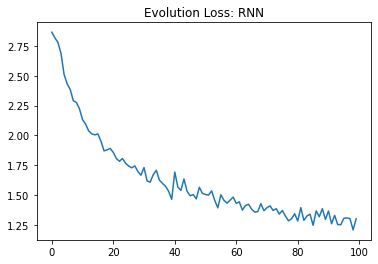

In [ ]:
# graficamos la curva de perdidas de entrenamiento 
plt.plot(all_losses, label = 'RNN')
plt.title('Evolution Loss: RNN')

Text(0.5, 1.0, 'Evolution Loss: LSTM')

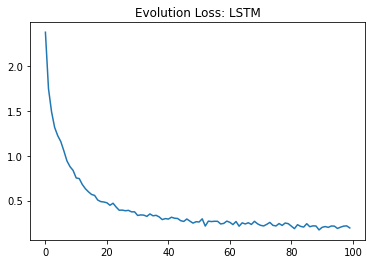

In [ ]:
# Analisis Grafico de la funcion de perdida
plt.plot(all_losses2, label = 'LSTM')
plt.title('Evolution Loss: LSTM')

### 7.1 Comparar los resultados

Al revisar las graficas ambas tienen un comportamiento similar. Claro esta que la evolucion de perdida considerando LSTM es ampliamente mejor dado que obtiene valores muy pequeños con respecto a RNN. A simple vista, el modelo LSTM con el ajuste de tasas de aprendizaje y numero de iteraciones consigue resultados muy por sobre LSTM. Posteriormente, en el desarrollo de esta laboratorio verificaremos con metricas esta conclusion.

Es importante señalar que lo que se pudo observar en el entrenamiento es que es mucho mas costoso en terminos computacionales LSTM, debido principalmente a su infraestructura y sus capas que interacturan y de que requiere un entrenamiento más intenso.

## 8. Evaluar los resultados

Construir las **matrices de confusión** para los dos modelos (RNN y LSTM). Indicando en cada fila el idioma real y en las columnas el idioma predicho. Graficar matriz de confusión como la vista en clases.

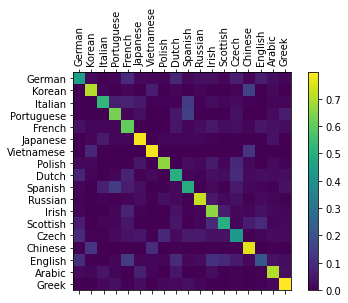

In [ ]:
# Para construir la matriz de confusion, reciclamos los codigos que se utilizaron en clases
# solo se generan dos funciones para separar RNN y LSTM

#Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluaternn(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluaternn(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

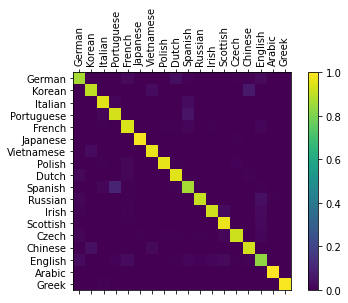

In [216]:
# Mismo procedimiento para LSTM

#Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluatelstm(line_tensor):
    lstm.hidden = lstm.init_hidden()
    output = lstm(line_tensor)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluatelstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### 8.1 Cálcular métricas

Calcular tasa de acierto, presición, sensibilidad (recall) y f1-score para ambos modelos. Comparar sus resultados

In [ ]:
# Metricas para RNN
y_pred_rnn = []
y_label_rnn = []
for iter in range(1, 10000+1):
  # Obtener una categoria y una palabra de forma aleatoria
  category, line, category_tensor, line_tensor = randomTrainingExample()
  label, label_id = categoryFromOutput(evaluaternn(line_tensor))
  y_pred_rnn.append(label)
  y_label_rnn.append(category)

print(classification_report(y_label_rnn, y_pred_rnn, target_names=all_categories))


              precision    recall  f1-score   support

      German       0.64      0.70      0.67       562
      Korean       0.57      0.74      0.65       573
     Italian       0.37      0.39      0.38       531
  Portuguese       0.47      0.47      0.47       561
      French       0.43      0.25      0.32       518
    Japanese       0.48      0.60      0.53       557
  Vietnamese       0.51      0.44      0.48       573
      Polish       0.76      0.82      0.79       549
       Dutch       0.54      0.64      0.59       569
     Spanish       0.74      0.56      0.64       568
     Russian       0.70      0.79      0.74       561
       Irish       0.66      0.66      0.66       554
    Scottish       0.76      0.67      0.71       600
       Czech       0.62      0.63      0.63       545
     Chinese       0.75      0.70      0.72       555
     English       0.61      0.49      0.54       543
      Arabic       0.46      0.49      0.47       536
       Greek       0.76    

In [ ]:
# Metricas para lstm
y_pred_lstm = []
y_label_lstm = []
for iter in range(1, 10000+1):
  # Obtener una categoria y una palabra de forma aleatoria
  category, line, category_tensor, line_tensor = randomTrainingExample()
  label, label_id = categoryFromOutput(evaluatelstm(line_tensor))
  y_pred_lstm.append(label)
  y_label_lstm.append(category)

print(classification_report(y_label_lstm, y_pred_lstm, target_names=all_categories))

              precision    recall  f1-score   support

      German       0.99      1.00      0.99       573
      Korean       0.90      0.92      0.91       582
     Italian       0.96      0.92      0.94       570
  Portuguese       0.94      0.96      0.95       561
      French       0.85      0.86      0.86       559
    Japanese       0.90      0.96      0.93       544
  Vietnamese       0.91      0.90      0.91       572
      Polish       1.00      0.99      1.00       555
       Dutch       0.98      0.93      0.95       589
     Spanish       0.93      0.94      0.93       560
     Russian       0.99      0.97      0.98       547
       Irish       0.93      0.88      0.90       542
    Scottish       0.97      0.97      0.97       549
       Czech       0.84      0.96      0.89       528
     Chinese       0.98      0.89      0.94       574
     English       0.93      0.94      0.93       529
      Arabic       0.88      0.81      0.85       556
       Greek       0.90    

### 8.2 Comparar los resultados
En general, tal como se vio en la curva de pérdidas de entrenamiento, la visualización de la matriz de confusión y el cálculo de las métricas en terminos agregados LSTM esta muy por sobre RNN. En ese sentido el accuracy de LSTM es 0,93 respecto de 0,6 de RNN.
En consecuencia el modelo LSTM explica muy bien este problema de lenguaje natural, asi lo demuestran todas las metricas y se destaca que en todas las clases demuestra buenos resultados, esto sirve para confirmar que teoricamente las LSTM explican muy bien problemas de NLP debido a que estos analisis se basan en analizar palabras de forma de secuencia.

## 9. Probar ambos modelos

Probar ambos modelos con las palabras: Dovesky, Jackson, Satoshi, Bekios y su apellido o nombre.

In [ ]:
lista = ['Dovesky', 'Jackson', 'Satoshi', 'Bekios', 'Ortega']

Modelo RNN

In [ ]:
for i in lista:
  print("{}----> el origen segun RNN es: {}".format(i, categoryFromOutput(evaluaternn(lineToTensor(i)))[0]))

Dovesky----> el origen segun RNN es: Czech
Jackson----> el origen segun RNN es: Scottish
Satoshi----> el origen segun RNN es: Italian
Bekios----> el origen segun RNN es: Greek
Ortega----> el origen segun RNN es: Spanish


Modelo LSTM

In [ ]:
for j in lista:
  print("{}----> el origen segun LSTM es: {}".format(j, categoryFromOutput(evaluatelstm(lineToTensor(j)))[0]))

Dovesky----> el origen segun LSTM es: Russian
Jackson----> el origen segun LSTM es: Scottish
Satoshi----> el origen segun LSTM es: Japanese
Bekios----> el origen segun LSTM es: Greek
Ortega----> el origen segun LSTM es: Spanish


Referencias

https://github.com/yk287/Name_Classification
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
https://github.com/spro/practical-pytorch
https://github.com/JB1984/PyTorch-LSTM-Name-Classification/blob/master/classifyNamesLSTMRNN.py
http://colah.github.io/posts/2015-08-Understanding-LSTMs/